In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
df = pd.read_csv("DataSet/HAM.csv")
df['image_id'] = df['image_id'].apply(lambda x: x + ".jpg")
class_counts = df['dx'].value_counts()

# Print the counts for each class
print(class_counts)

dx
bkl      7000
nv       7000
df       7000
mel      7000
vasc     7000
bcc      7000
akiec    7000
Name: count, dtype: int64


In [3]:
# Define image dimensions and batch size
img_size = (200, 200)
batch_size = 16

# Create data generators for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [4]:
train_temp_df, test_valid_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['dx'])
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42, stratify=test_valid_df['dx'])

# Splitting the temporary set into validation and test sets
# This step is optional if you want to keep a separate validation set
# test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42, stratify=test_valid_df['dx'])

# Concatenating the paths for images
df['image_id'] = 'DataSet/Combined/' + df['image_id']

# Splitting the data into training, validation, and test sets based on the new indices
train_df = df[df.index.isin(train_temp_df.index)]
valid_df = df[df.index.isin(valid_df.index)]
test_df = df[df.index.isin(test_df.index)]

# Verify the class distribution in each set
print("Train class distribution:")
print(train_df['dx'].value_counts())
print("\nValidation class distribution:")
print(valid_df['dx'].value_counts())
print("\nTest class distribution:")
print(test_df['dx'].value_counts())

Train class distribution:
dx
bkl      4900
df       4900
nv       4900
mel      4900
vasc     4900
bcc      4900
akiec    4900
Name: count, dtype: int64

Validation class distribution:
dx
bkl      1050
nv       1050
df       1050
mel      1050
vasc     1050
bcc      1050
akiec    1050
Name: count, dtype: int64

Test class distribution:
dx
bkl      1050
df       1050
mel      1050
vasc     1050
bcc      1050
nv       1050
akiec    1050
Name: count, dtype: int64


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 34300 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.


In [6]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))


x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation=swish)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation=swish)(x)
x = Dropout(0.5)(x)

predictions = Dense(7, activation='softmax')(x)  # Replace NUM_CLASSES with the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=150,  # You can adjust the number of epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/150
2144/2144 [==============================] - 634s 287ms/step - loss: 1.7798 - accuracy: 0.2633 - val_loss: 2.0815 - val_accuracy: 0.1646
Epoch 2/150
2144/2144 [==============================] - 605s 282ms/step - loss: 1.7387 - accuracy: 0.2692 - val_loss: 1.6896 - val_accuracy: 0.3030
Epoch 3/150
2144/2144 [==============================] - 607s 283ms/step - loss: 1.6287 - accuracy: 0.3277 - val_loss: 1.6449 - val_accuracy: 0.2854
Epoch 4/150
2144/2144 [==============================] - 603s 281ms/step - loss: 1.4759 - accuracy: 0.4088 - val_loss: 1.3610 - val_accuracy: 0.4690
Epoch 5/150
2144/2144 [==============================] - 602s 281ms/step - loss: 1.3379 - accuracy: 0.4688 - val_loss: 1.2680 - val_accuracy: 0.4943
Epoch 6/150
2144/2144 [==============================] - 602s 281ms/step - loss: 1.2815 - accuracy: 0.4911 - val_loss: 1.2540 - val_accuracy: 0.5027
Epoch 7/150
2144/2144 [==============================] - 602s 281ms/step - loss: 1.2275 - accuracy: 0.5226

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

460/460 [==============================] - 42s 92ms/step - loss: 0.5879 - accuracy: 0.8750
Test accuracy: 87.50%


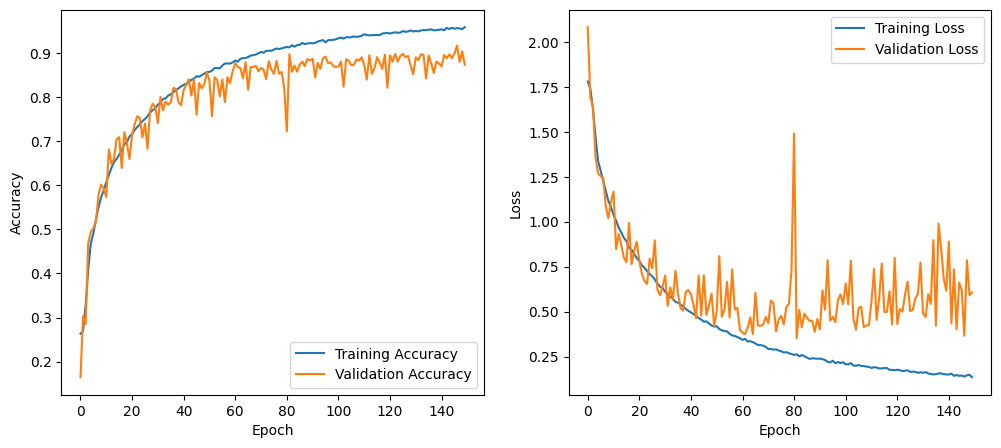

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
model.save('Check_resnet18_model.h5')